# Overview
- Get data from kaggle and explore
- Prepare data for modeling
- Basic model using CNN Classifier
- Save, load and evaluate again
- Run for some more epochs
- Make prediction again

In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

# Get data and Explore

In [2]:
# upload kaggle API file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saimislam","key":"a3e06183b8072352e5ef8e53240d343a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

## Download image and inspect path

In [4]:
#!kaggle datasets download -p destination -d download-link
!kaggle datasets download -p /content/drive/MyDrive/Deep\ Learning/data -d n0obcoder/mobile-gallery-image-classification-data

 99% 856M/866M [00:07<00:00, 112MB/s]
100% 866M/866M [00:08<00:00, 113MB/s]


In [5]:
import zipfile
zip_file_path = '/content/drive/MyDrive/Deep Learning/data/mobile-gallery-image-classification-data.zip'
zip_ref = zipfile.ZipFile(zip_file_path, "r")
destination_path = "/content/drive/MyDrive/Deep Learning/data"
zip_ref.extractall(destination_path)
zip_ref.close()

In [6]:
import os
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 6 directories and 0 images in '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/train'.
There are 0 directories and 163 images in '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/train/Cars'.
There are 0 directories and 175 images in '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/train/Memes'.
There are 0 directories and 240 images in '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/train/Mountains'.
There are 0 directories and 237 images in '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/train/Selfies'.
There are 0 directories and 287 images in '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/train/Trees'.
There are 0 directories and 164 images in '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/train/Whatsapp_Screenshots'.


In [7]:
# Another way to findout how many image on a directory
dir = '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/train/Selfies'
len(os.listdir(dir))

237

In [8]:
# Get the class name programmatically
import pathlib
data_dir = pathlib.Path("/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/train/")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Cars' 'Memes' 'Mountains' 'Selfies' 'Trees' 'Whatsapp_Screenshots']


## View random image from data

In [9]:
def view_random_image(target_dir, target_class):
  # We will view image from here
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder+'/'+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off');
  print(f"Image shape {img.shape}")

  return img

Image shape (477, 476, 3)


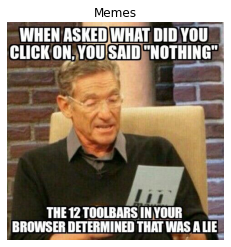

In [10]:
img = view_random_image(target_dir="/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/train/",
                        target_class='Memes')

In [11]:
class_names

array(['Cars', 'Memes', 'Mountains', 'Selfies', 'Trees',
       'Whatsapp_Screenshots'], dtype='<U20')

Image shape (331, 586, 3)
Image shape (560, 700, 3)
Image shape (3456, 5184, 3)
Image shape (1300, 957, 3)
Image shape (900, 1300, 3)
Image shape (1920, 1080, 3)


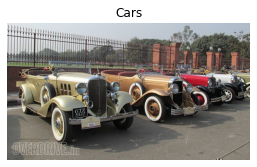

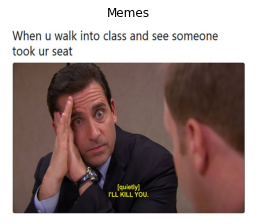

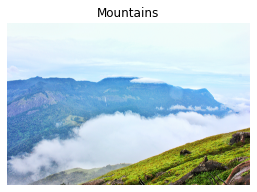

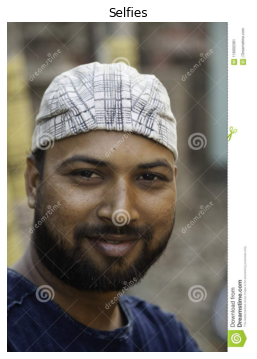

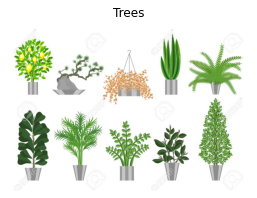

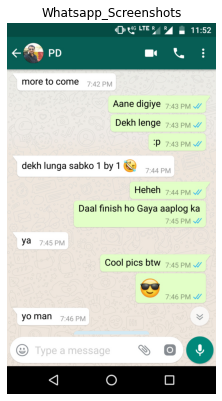

In [12]:
for i in class_names:
  k = 1
  plt.figure(figsize=(20,15))
  plt.subplot(2,4,k)
  rand_img = view_random_image(target_dir="/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/train/",
                        target_class=i)
  k+=1

# Prepare data for model

In [14]:
# Define training and test directory paths
train_dir = '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/train/'
test_dir = '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/test/'

In [112]:
# Create augmented data generator instance
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.3,
                                   dtype='float32')

val_datagen = ImageDataGenerator(rescale=1/255.,
                                 data_format='channels_last', 
                                 validation_split=0.3,
                                 dtype='float32')

In [113]:
# Load data(data, label) from directory and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical',
                                               subset="training")
val_data = val_datagen.flow_from_directory(train_dir,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='categorical',
                                           subset="validation")

Found 888 images belonging to 6 classes.
Found 378 images belonging to 6 classes.


In [114]:
len(train_data[0][1]), len(val_data[0][1])

(32, 32)

In [115]:
# label
train_data[0][1][0]

array([0., 0., 0., 1., 0., 0.], dtype=float32)

# Basic model Buildinig a CNN Classifier

## Model Architecture

In [116]:
model = Sequential([
  Conv2D(16, 3, padding='same', activation='relu', input_shape=(224,224,3)),
  MaxPool2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(6, activation='softmax')
])

model.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=['accuracy'])

In [117]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)            

## Fit and evaluate model

In [118]:
history = model.fit(train_data,
                    epochs=4,
                    batch_size=32,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/4
11/28 [==========>...................] - ETA: 15s - loss: 2.6642 - accuracy: 0.2238

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


28/28 [==============================] - 35s 1s/step - loss: 1.9245 - accuracy: 0.3739 - val_loss: 1.0989 - val_accuracy: 0.5899
Epoch 2/4
28/28 [==============================] - 35s 1s/step - loss: 0.9252 - accuracy: 0.6745 - val_loss: 0.6955 - val_accuracy: 0.7831
Epoch 3/4
28/28 [==============================] - 35s 1s/step - loss: 0.6956 - accuracy: 0.7646 - val_loss: 0.6497 - val_accuracy: 0.7672
Epoch 4/4
28/28 [==============================] - 34s 1s/step - loss: 0.5919 - accuracy: 0.7950 - val_loss: 0.8234 - val_accuracy: 0.7328


In [119]:
model.evaluate(val_data)

12/12 [==============================] - 8s 656ms/step - loss: 0.8234 - accuracy: 0.7328


[0.8233935832977295, 0.7328042387962341]

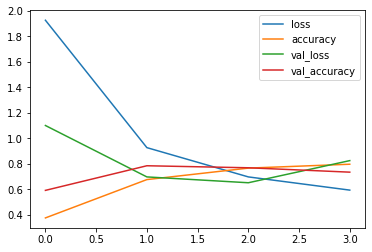

In [120]:
pd.DataFrame(history.history).plot()

## Make prediction and plot

In [121]:
print(class_names)

['Cars' 'Memes' 'Mountains' 'Selfies' 'Trees' 'Whatsapp_Screenshots']


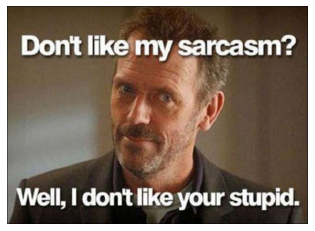

In [122]:
memes = mpimg.imread("/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/test/house.jpg")
# View image
plt.imshow(memes)
plt.axis(False);

In [62]:
memes.shape

(477, 660, 3)

In [123]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads in an image from filename, turns it into a tensor and reshape into (224,224,3).
  """
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img,[img_shape, img_shape])
  img = img/255.
  return img

In [124]:
memes = load_and_prep_image('/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/test/house.jpg')
memes.shape

TensorShape([224, 224, 3])

In [125]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

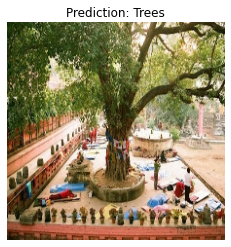

In [126]:
file_name = '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/test/mahabodhi_tree.jpg'
pred_and_plot(model, file_name, class_names)

In [ ]:
# /content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/test/maruti800.jpg

In [127]:
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/test"):
  test_data = filenames

In [128]:
test_data

['dwight.jpg',
 'house.jpg',
 'mahabodhi_tree.jpg',
 'maruti800.jpg',
 'michael.jpeg',
 'modi_selfie.jpg',
 'sachin_selfie.jpg']

In [129]:
class_names

array(['Cars', 'Memes', 'Mountains', 'Selfies', 'Trees',
       'Whatsapp_Screenshots'], dtype='<U20')

In [130]:
test_classes = ['Memes', 'Memes', 'Trees', 'Cars', 'Memes', 'Selfies','Selfies']
len(test_classes), len(test_data)

(7, 7)

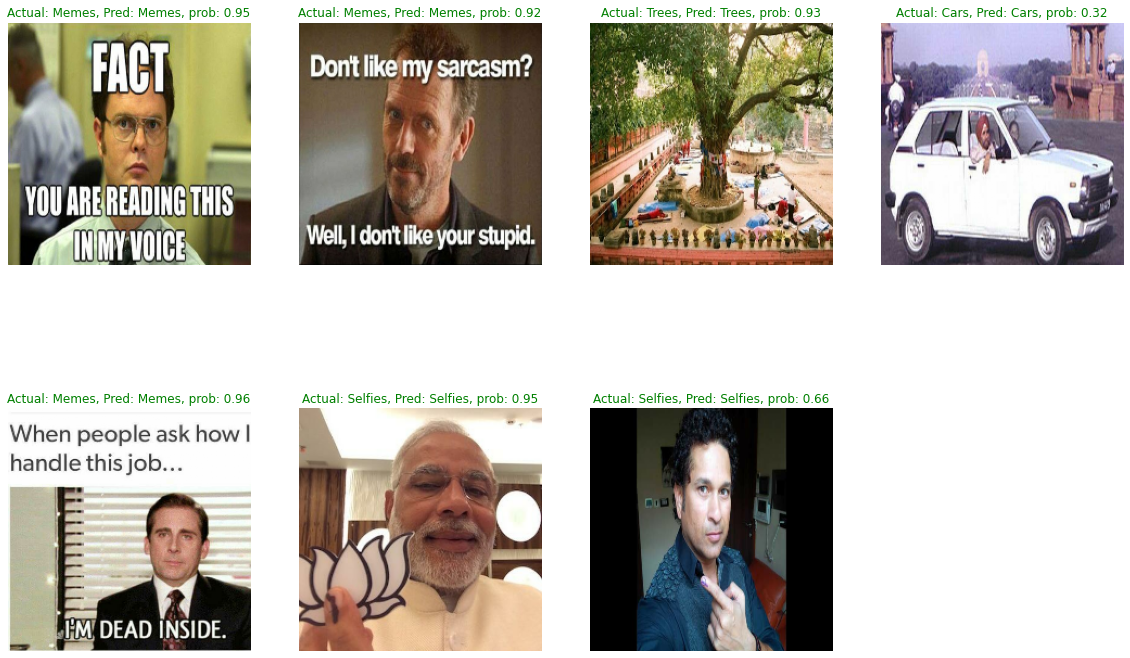

In [131]:
# Make preds on test data provided
import os
import random

# test_dir = '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/test/'
plt.figure(figsize=(20, 13))
for i in range(len(test_data)): 
  test_name = test_data[i]
  filepath = test_dir + test_name

  # Load the image and make predictions
  img = load_and_prep_image(filepath) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(2, 4, i+1)
  plt.imshow(img)
  if test_classes[i] == pred_class:
    title_color = "g"
  else:
     title_color = "r"
  plt.title(f"Actual: {test_classes[i]}, Pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

# Save and load model

In [137]:
model.save('/content/drive/MyDrive/Deep Learning/model/mobile_gallery_image_classification')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep Learning/model/mobile_gallery_image_classification/assets


In [138]:
# Load a model and evaluate
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Deep Learning/model/mobile_gallery_image_classification')
loaded_model.evaluate(val_data)

12/12 [==============================] - 8s 669ms/step - loss: 0.8234 - accuracy: 0.7328


[0.8233934640884399, 0.7328042387962341]

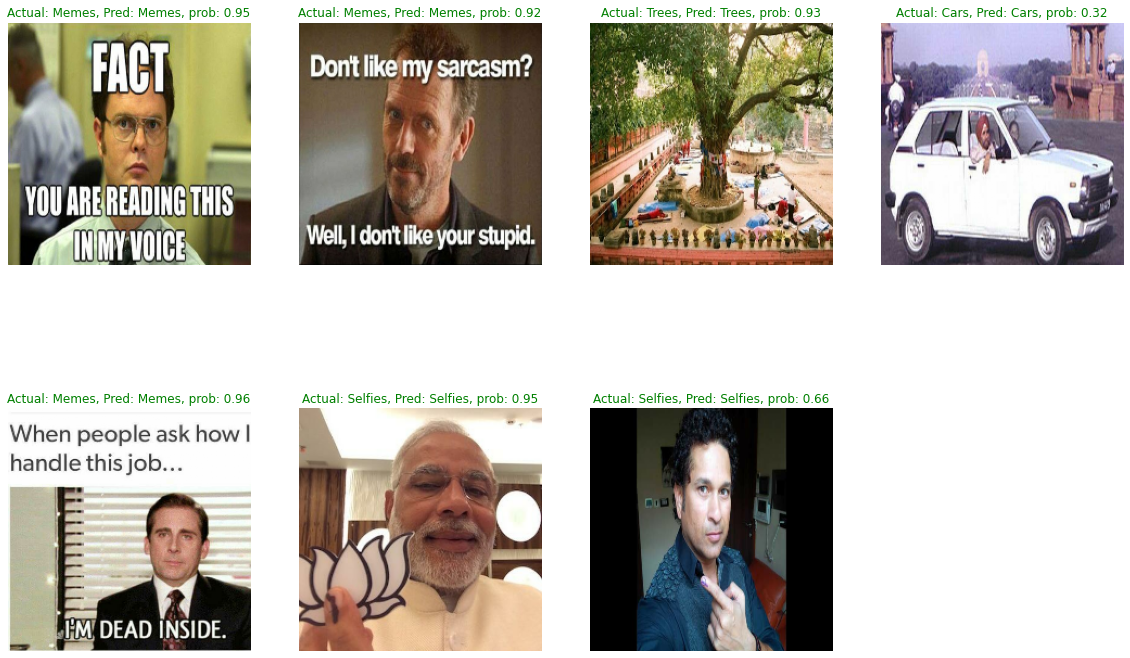

In [139]:
# Make preds on test data provided
import os
import random

# test_dir = '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/test/'
plt.figure(figsize=(20, 13))
for i in range(len(test_data)): 
  test_name = test_data[i]
  filepath = test_dir + test_name

  # Load the image and make predictions
  img = load_and_prep_image(filepath) # don't scale images for EfficientNet predictions
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(2, 4, i+1)
  plt.imshow(img)
  if test_classes[i] == pred_class:
    title_color = "g"
  else:
     title_color = "r"
  plt.title(f"Actual: {test_classes[i]}, Pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

# Run for some more epochs

In [140]:
history_2 = loaded_model.fit(train_data,
                    epochs=2,
                    batch_size=32,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/2
26/28 [==========================>...] - ETA: 1s - loss: 0.5924 - accuracy: 0.8034

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


28/28 [==============================] - 35s 1s/step - loss: 0.5907 - accuracy: 0.8041 - val_loss: 0.6053 - val_accuracy: 0.7857
Epoch 2/2
28/28 [==============================] - 34s 1s/step - loss: 0.5344 - accuracy: 0.8041 - val_loss: 0.6023 - val_accuracy: 0.8175


In [141]:
history_2 = loaded_model.fit(train_data,
                    epochs=4,
                    batch_size=32,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/4
15/28 [===============>..............] - ETA: 12s - loss: 0.3750 - accuracy: 0.8581

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


28/28 [==============================] - 35s 1s/step - loss: 0.4530 - accuracy: 0.8300 - val_loss: 0.7070 - val_accuracy: 0.7672
Epoch 2/4
28/28 [==============================] - 34s 1s/step - loss: 0.4255 - accuracy: 0.8536 - val_loss: 0.4222 - val_accuracy: 0.8757
Epoch 3/4
28/28 [==============================] - 34s 1s/step - loss: 0.4272 - accuracy: 0.8547 - val_loss: 0.7359 - val_accuracy: 0.7910
Epoch 4/4
28/28 [==============================] - 34s 1s/step - loss: 0.3745 - accuracy: 0.8784 - val_loss: 0.5550 - val_accuracy: 0.8201


In [142]:
loaded_model.evaluate(val_data)

12/12 [==============================] - 8s 660ms/step - loss: 0.5550 - accuracy: 0.8201


[0.5549846291542053, 0.820105791091919]

# Save best model

In [143]:
loaded_model.save('/content/drive/MyDrive/Deep Learning/model/mobile_gallery_image_classification')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep Learning/model/mobile_gallery_image_classification/assets


In [144]:
# Load a model and evaluate
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Deep Learning/model/mobile_gallery_image_classification')
loaded_model.evaluate(val_data)

12/12 [==============================] - 8s 670ms/step - loss: 0.5550 - accuracy: 0.8201


[0.5549846887588501, 0.820105791091919]

# Final prediction

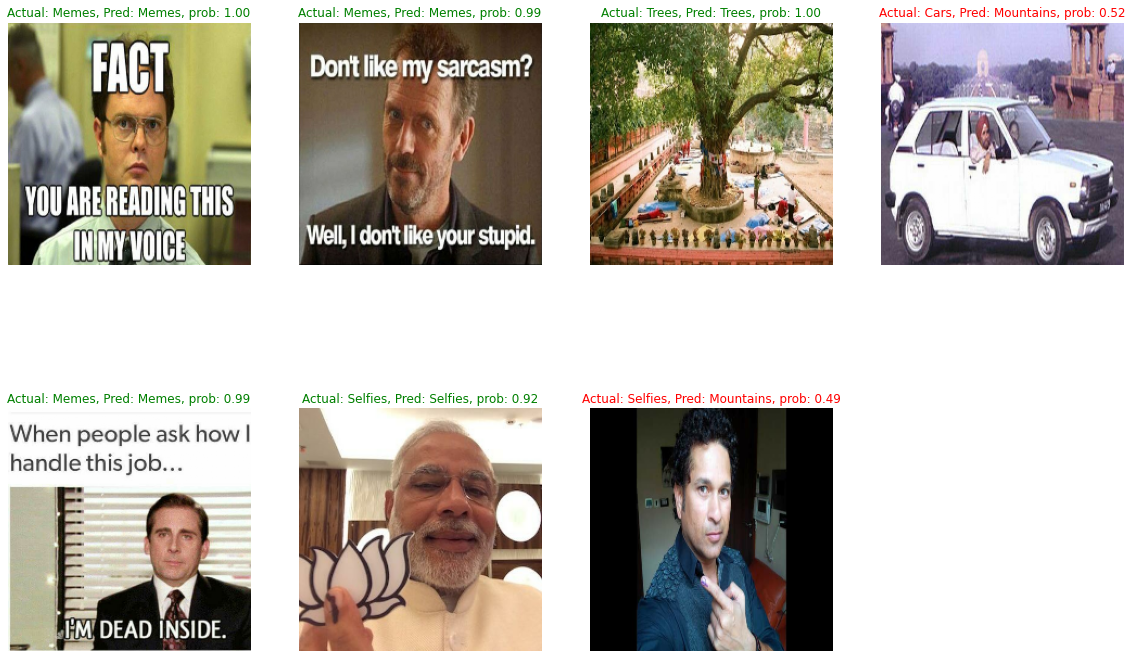

In [145]:
# Make preds on test data provided
import os
import random

# test_dir = '/content/drive/MyDrive/Deep Learning/data/mobile_gallery_image_classification/test/'
plt.figure(figsize=(20, 13))
for i in range(len(test_data)): 
  test_name = test_data[i]
  filepath = test_dir + test_name

  # Load the image and make predictions
  img = load_and_prep_image(filepath) # don't scale images for EfficientNet predictions
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(2, 4, i+1)
  plt.imshow(img)
  if test_classes[i] == pred_class:
    title_color = "g"
  else:
     title_color = "r"
  plt.title(f"Actual: {test_classes[i]}, Pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);